In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import hmp
from pathlib import Path
from mne.io import read_info
from hmpai.data import StageFinder, SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, SAT2_STAGES_ACCURACY, SAT2_STAGES_SPEED, AR_STAGES
from hmpai.ica import ICA
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
# info_path = Path("../data/sat2/preprocessed_500hz/preprocessed_S1_raw.fif")
info_path = DATA_PATH / "sat1/preprocessed/processed_0001_epo.fif"
positions = read_info(info_path)

In [ ]:
epoched_data_paths = [
    DATA_PATH / 'sat2/data_part1.nc',
    DATA_PATH / 'sat2/data_part2.nc',
]
conditions = ["accuracy", "speed"]
labels = {"accuracy": SAT1_STAGES_ACCURACY, "speed": SAT1_STAGES_SPEED}

cpus = 12

for epoched_data_path in epoched_data_paths:
    epoched_data = xr.load_dataset(epoched_data_path)
    for participant in epoched_data.participant.values:
        epoched_data_participant = epoched_data.sel(participant=[participant])
        print(epoched_data_participant.data.shape)
        print(participant)
        print(epoched_data_participant)
        stage_finder = StageFinder(
            epoched_data_participant,
            labels,
            conditions=conditions,
            cpus=cpus,
            fit_function="fit_single",
            fit_args={"starting_points": 100, "tolerance": 1e-5},
            verbose=False,
            condition_variable="event_name",
            condition_method="contains",
        )
        stage_finder.fit_model()
        stage_finder.visualize_model(positions)
        input("Enter to continue (if model is correct), esc to cancel")
        stage_data = stage_finder.label_model()
        stage_data.to_netcdf(Path("../data/sat2") / (f"stage_data_{participant}.nc"))

Transforming epoched data to principal component (PC) space


/workspace/forks/hmp/hmp/utils.py:508: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


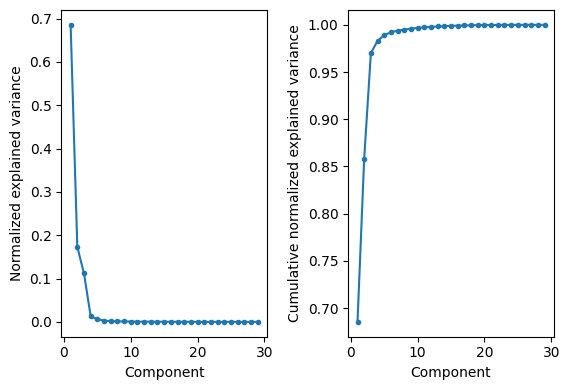

Fitting HMP model for accuracy condition
Estimating 4 events model with 100 starting point(s)


  0%|          | 0/100 [00:02<?, ?it/s]

parameters estimated for 4 events model
Fitting HMP model for speed condition
Estimating 3 events model with 100 starting point(s)


  0%|          | 0/100 [00:00<?, ?it/s]

parameters estimated for 3 events model


In [3]:
cpus = 8

epoched_data_path = DATA_PATH / "sat2/data_100hz.nc"
output_path = DATA_PATH / "sat2/stage_data_100hz.nc"

conditions = ["accuracy", "speed"]
labels = {"accuracy": SAT1_STAGES_ACCURACY, "speed": SAT1_STAGES_SPEED}

stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    fit_function="fit_single",  # n_events is extracted from the amount of labels in 'conditions' variable
    fit_args={"starting_points": 100},
    verbose=False,
    condition_variable="event_name",
    condition_method="contains",
)
stage_finder.fit_model()

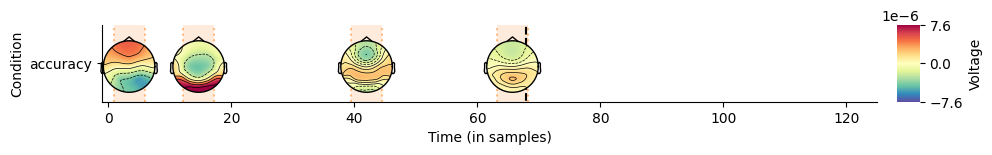

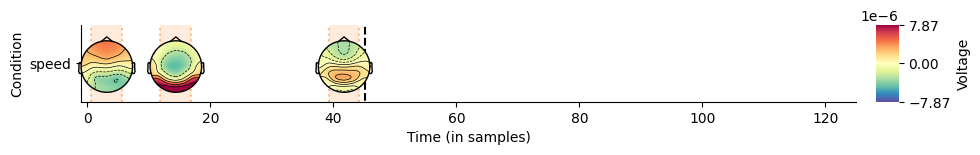

In [4]:
# Visualize model to check if fitting was done as expected

stage_finder.visualize_model(positions)

In [5]:
# Save models
hmp.utils.save_fit(stage_finder.fits[0], "100hz_accuracy.nc")
hmp.utils.save_fit(stage_finder.fits[1], "100hz_speed.nc")

100hz_accuracy.nc saved
100hz_speed.nc saved


In [6]:
output_path = DATA_PATH / "sat2/window_stage_data_100hz.nc"
stage_data = stage_finder.label_model(stage_finder.__label_samples_around_bump__, {"window": (5, 5)})

Labeling dataset for accuracy condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing participant S6
Processing participant S7
Processing participant S8
Processing participant S9
Labeling dataset for speed condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing participant S6
Processing participant S7
Processing participan

In [7]:
stage_data.to_netcdf(output_path)

In [ ]:
# Add labels to dataset
stage_data = stage_finder.label_model()

In [6]:
# Save labelled dataset
output_path = Path("../data/sat2/stage_data_part1.nc")
stage_data.to_netcdf(output_path)

In [7]:
# Save models
hmp.utils.save_fit(stage_finder.fits[0], "../models/100hz_accuracy_sat2.nc")
hmp.utils.save_fit(stage_finder.fits[1], "../models/100hz_speed_sat2.nc")

../models/100hz_accuracy_sat2.nc saved
../models/100hz_speed_sat2.nc saved
